# Initializing project

Install and load Python dependencies

In [3]:
from tensorflow import keras
from keras.layers import *
from keras.models import *

import os
import math
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from google.colab import files
from google.colab import drive
from IPython.display import clear_output
from IPython.display import display

Download and unzip the DIV2K [dataset](https://data.vision.ee.ethz.ch/cvl/DIV2K/)

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

In [3]:
!unzip "DIV2K_train_HR.zip"
!unzip "DIV2K_valid_HR.zip"
!mv ./DIV2K_valid_HR/* ./DIV2K_train_HR
clear_output()

OR get dataset from drive

In [ ]:
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/School/2022-2023/Winter/ELECENG 4TN4/sr_cnn/DIV2K_train_HR.zip"
!unzip "/content/drive/MyDrive/School/2022-2023/Winter/ELECENG 4TN4/sr_cnn/DIV2K_valid_HR.zip"
!mv ./DIV2K_valid_HR ./DIV2K_train_HR
clear_output()
drive.flush_and_unmount()

# Define the model


Define PSNR and SSIM metrics

In [54]:
def tf_PSNR(y_true, y_pred):
  mse = np.mean((y_true - y_pred) ** 2)
  return 10 * math.log10(255.0**2 / mse)

def PSNR(y_true, y_pred):
  return tf.py_function(
      tf_PSNR, inp=[y_true, y_pred], Tout=tf.float32, name="PSNR"
  )

def SSIM(y_true, y_pred):
  y_true = tf.expand_dims(y_true, axis=-1)
  y_pred = tf.expand_dims(y_pred, axis=-1)

  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 255.0))

In [31]:
def get_model(scale):
  kernel_size = 3
  conv_args = {
    "activation": "relu",
    "padding": "same",
  }

  input = Input(shape=(None, None, 1))

  input = input / 255

  x = Conv2D(32, kernel_size, **conv_args)(input)
  x = Conv2D(64, kernel_size, **conv_args)(x)
  x = Conv2D(128, kernel_size, **conv_args)(x)
  x = UpSampling2D(scale)(x)
  x = Conv2D(64, kernel_size, **conv_args)(x)
  x = Conv2D(32, kernel_size, **conv_args)(x)
  x = Conv2D(1, kernel_size, activation=None, padding='same')(x)
  x = Activation('tanh')(x)
  x = x * 127.5 + 127.5

  model = Model([input], x)

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  model.compile(loss='mse', optimizer=optimizer, metrics=[PSNR, SSIM])
  model.summary()
  
  return model

# Processing Data

In [6]:
class Encoder:
  def __init__(self, image):
    self.image = image
    self.ycbcr = self.rgb2ycbcr(cv2.split(image))

  def encode(self):
    '''
    Downsamples image in YCbCr colorspace
    Returns: Downsampled Y, Cb, Cr channels as tuple
    '''
    B, G, R = cv2.split(self.image)

    ycbcr = self.rgb2ycbcr((R, G, B))

    # Downsample Y by a factor of 2
    Y = self.downsample(ycbcr[0], 2)

    # Downsample Cb and Cr by a factor of 4
    Cb = self.downsample(ycbcr[1], 4)
    Cr = self.downsample(ycbcr[2], 4)

    self.ycbcr = (Y, Cb, Cr)
    
  def rgb2ycbcr(self, rgb):
    '''
    Convert RGB colorspace to YCbCr colorspace
    Parameters: R, G, B channels
    Returns: Y, Cb, Cr channels as tuple
    '''
    R, G, B = rgb
    Y = 0.257*R + 0.504*G + 0.098*B + 16
    Cb = -0.148*R - 0.291*G + 0.439*B + 128
    Cr = 0.439*R - 0.368*G - 0.071*B + 128

    Y = np.clip(Y, 0, 255).astype(np.uint8)
    Cb = np.clip(Cb, 0, 255).astype(np.uint8)
    Cr = np.clip(Cr, 0, 255).astype(np.uint8)

    return (Y, Cb, Cr)

  def downsample(self, channel, factor):
    return channel[::factor, ::factor]
    
  def get_ycbcr(self):
    return self.ycbcr

In [7]:
def get_data():
  x_Y = []
  x_Cb = []
  x_Cr = []
  y_Y = []
  y_Cb = []
  y_Cr = []

  imgs = os.listdir("./DIV2K_train_HR")

  for img_path in tqdm(imgs):
    img = cv2.imread(f"./DIV2K_train_HR/{img_path}", 1)
    B, G, R = cv2.split(img)

    encoder = Encoder(img)
    ycbcr = encoder.rgb2ycbcr((R, G, B))
    y_channel, Cb_channel, Cr_channel = ycbcr

    Y_out = cv2.resize(y_channel, (256, 256), interpolation=cv2.INTER_AREA)
    Cb_out = cv2.resize(Cb_channel, (256, 256), interpolation=cv2.INTER_AREA)
    Cr_out = cv2.resize(Cr_channel, (256, 256), interpolation=cv2.INTER_AREA)

    Y_in = encoder.downsample(Y_out, 2)
    Cb_in = encoder.downsample(Cb_out, 4)
    Cr_in = encoder.downsample(Cr_out, 4)

    x_Y.append(Y_in)
    x_Cb.append(Cb_in)
    x_Cr.append(Cr_in)
    y_Y.append(Y_out)
    y_Cb.append(Cb_out)
    y_Cr.append(Cr_out)

  x_Y = np.array(x_Y)
  x_Cb = np.array(x_Cb)
  x_Cr = np.array(x_Cr)
  y_Y = np.array(y_Y)
  y_Cb = np.array(y_Cb)
  y_Cr = np.array(y_Cr)

  return x_Y, x_Cb, x_Cr, y_Y, y_Cb, y_Cr

In [34]:
Y_model = get_model(2)
Cb_model = get_model(4)
Cr_model = get_model(4)

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_126 (Conv2D)         (None, None, None, 32)    320       
                                                                 
 conv2d_127 (Conv2D)         (None, None, None, 64)    18496     
                                                                 
 conv2d_128 (Conv2D)         (None, None, None, 128)   73856     
                                                                 
 up_sampling2d_21 (UpSamplin  (None, None, None, 128)  0         
 g2D)                                                            
                                                                 
 conv2d_129 (Conv2D)         (None, None, None, 64)    73792     
                                                          

In [35]:
x_Y, x_Cb, x_Cr, y_Y, y_Cb, y_Cr = get_data()

100%|██████████| 900/900 [04:20<00:00,  3.46it/s]


# Training model

In [40]:
from sklearn.model_selection import train_test_split

batch_size = 4
epochs = 100

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
def tbCallback(model):
  return tf.keras.callbacks.TensorBoard(log_dir=f'./graph/{model}/', histogram_freq=0, write_graph=True, write_images=True)
def save_model_callback(model):
  return tf.keras.callbacks.ModelCheckpoint(
      f'model/{model}.h5',
      monitor='val_loss',
      verbose=1,
      save_best_only=True,
      mode='min',
      save_freq='epoch'
  )

x_train, x_val, y_train, y_val = train_test_split(x_Y, y_Y, test_size=0.2, random_state=42)
print("\n\nTraining Y channel model... \n")
Y_history = Y_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[save_model_callback('Y_model'), tbCallback('Y_model'), stop_early])

x_train, x_val, y_train, y_val = train_test_split(x_Cb, y_Cb, test_size=0.2, random_state=42)
print("\n\nTraining Cb channel model... \n")
Cb_history = Cb_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[save_model_callback('Cb_model'), tbCallback('Cb_model'), stop_early])

x_train, x_val, y_train, y_val = train_test_split(x_Cr, y_Cr, test_size=0.2, random_state=42)
print("\n\nTraining Cr channel model... \n")
Cr_history = Cr_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[save_model_callback('Cr_model'), tbCallback('Cr_model'), stop_early])



Training Cr channel model... 

Epoch 1/100
176/180 [============================>.] - ETA: 0s - loss: 1770.1461 - PSNR: 18.3647 - SSIM: 0.3984
Epoch 1: val_loss improved from inf to 1218.29028, saving model to model/Cr_model.h5
180/180 [==============================] - 5s 13ms/step - loss: 1757.5323 - PSNR: 18.3645 - SSIM: 0.3982 - val_loss: 1218.2903 - val_PSNR: 17.3970 - val_SSIM: 0.5005
Epoch 2/100
179/180 [============================>.] - ETA: 0s - loss: 611.5491 - PSNR: 20.9001 - SSIM: 0.5422
Epoch 2: val_loss improved from 1218.29028 to 437.94235, saving model to model/Cr_model.h5
180/180 [==============================] - 2s 11ms/step - loss: 611.3093 - PSNR: 20.8983 - SSIM: 0.5409 - val_loss: 437.9424 - val_PSNR: 22.1963 - val_SSIM: 0.5796
Epoch 3/100
180/180 [==============================] - ETA: 0s - loss: 416.6898 - PSNR: 22.6390 - SSIM: 0.6125
Epoch 3: val_loss did not improve from 437.94235
180/180 [==============================] - 2s 11ms/step - loss: 416.6898 - PSN

In [41]:
np.save('./metrics/Y_history.npy', Y_history.history)
np.save('./metrics/Cb_history.npy', Cb_history.history)
np.save('./metrics/Cr_history.npy', Cr_history.history)

In [29]:
def plot_metrics(history, metric, title=""):
    plt.plot(history[metric])
    plt.plot(history[f'val_{metric}'])
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(['training', 'validation'], loc='center right')
    plt.savefig(f'metrics/plots/{title}', bbox_inches='tight')
    plt.show()

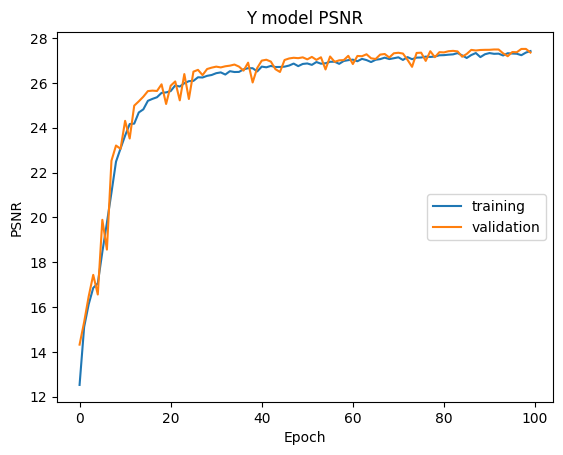

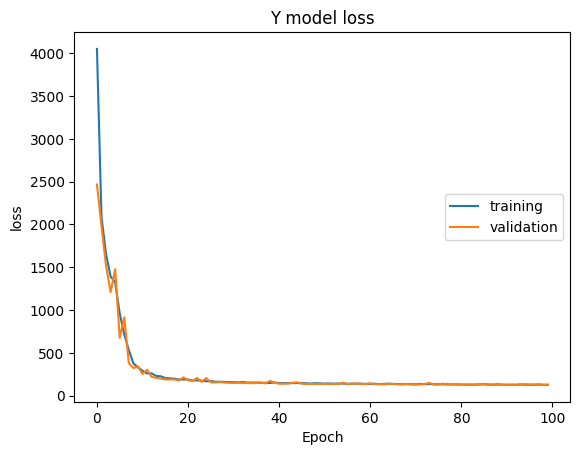

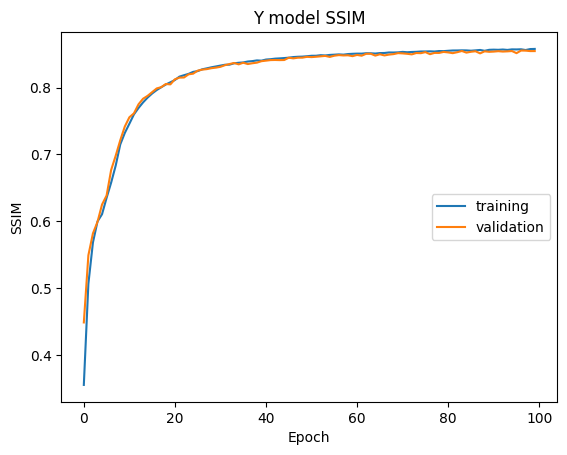

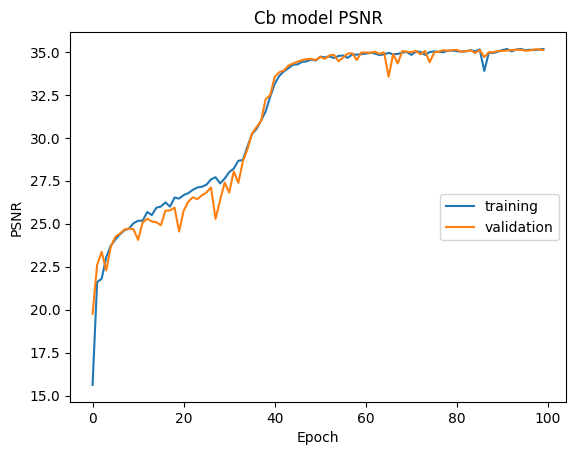

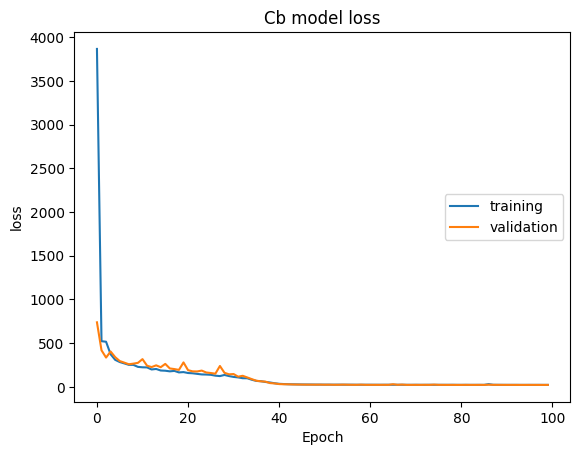

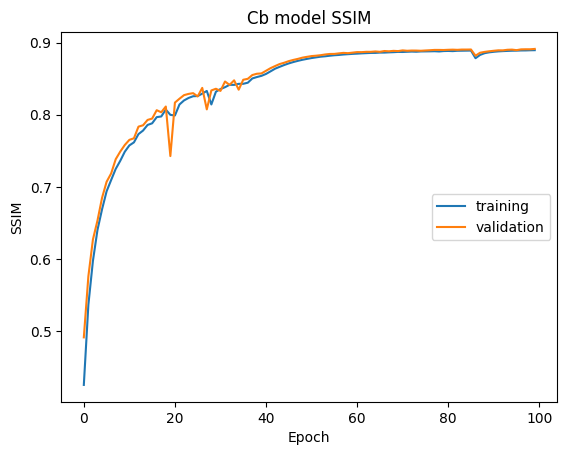

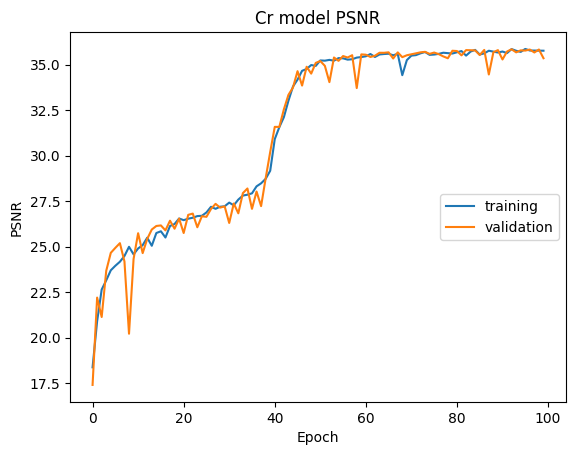

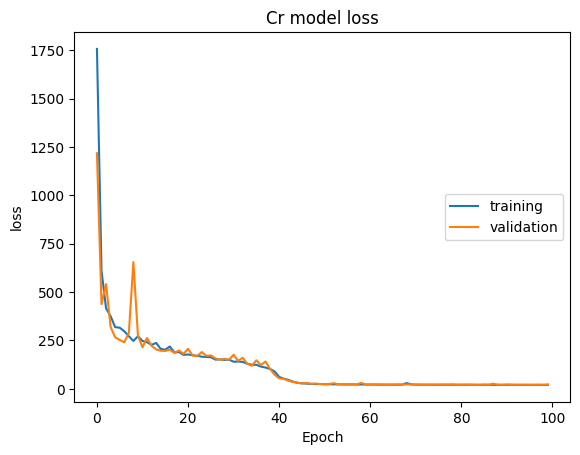

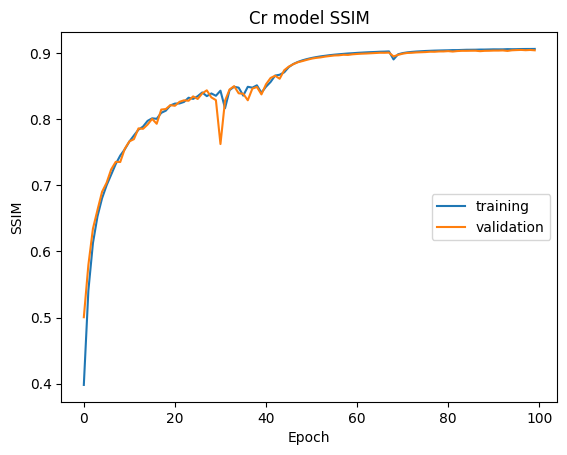

In [30]:
Y_history=np.load('metrics/Y_history.npy', allow_pickle=True).item()
Cb_history=np.load('metrics/Cb_history.npy', allow_pickle=True).item()
Cr_history=np.load('metrics/Cr_history.npy', allow_pickle=True).item()

plot_metrics(Y_history, 'PSNR', 'Y model PSNR')
plot_metrics(Y_history, 'loss', 'Y model loss')
plot_metrics(Y_history, 'SSIM', 'Y model SSIM')
plot_metrics(Cb_history, 'PSNR', 'Cb model PSNR')
plot_metrics(Cb_history, 'loss', 'Cb model loss')
plot_metrics(Cb_history, 'SSIM', 'Cb model SSIM')
plot_metrics(Cr_history, 'PSNR', 'Cr model PSNR')
plot_metrics(Cr_history, 'loss', 'Cr model loss') 
plot_metrics(Cr_history, 'SSIM', 'Cr model SSIM')

# Save model and predict




In [ ]:
!zip -r ./graph.zip ./graph
!zip -r ./metrics.zip ./metrics

In [45]:
files.download('./model/Y_model.h5')
files.download('./model/Cb_model.h5')
files.download('./model/Cr_model.h5')
files.download('./graph.zip')
files.download('./metrics.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
class Decoder:
    def __init__(self, ycbcr, original_size):
        self.ycbcr = ycbcr
        self.original_size = original_size

    def decode(self):
        """
        Upsamples image in YCbCr colorspace
        Parameters: Size of image to upsample to
        Returns: Reconstructed image
        """
        Y, Cb, Cr = self.infer()

        R, G, B = self.ycbcr2rgb((Y, Cb, Cr))

        self.image = cv2.merge((B, G, R))
        return cv2.merge((B, G, R))

    def ycbcr2rgb(self, ycbcr):
        """
        Convert YCbCr colorspace to RGB colorspace
        Parameters: Y, Cb, Cr channels
        Returns: R, G, B channels as tuple
        """
        Y, Cb, Cr = ycbcr
        Y = self.crop(Y)
        Cb = self.crop(Cb)
        Cr = self.crop(Cr)

        R = 1.164 * (Y - 16) + 1.596 * (Cr - 128)
        G = 1.164 * (Y - 16) - 0.392 * (Cb - 128) - 0.813 * (Cr - 128)
        B = 1.164 * (Y - 16) + 2.017 * (Cb - 128)

        R = np.clip(R, 0, 255).astype(np.uint8)
        G = np.clip(G, 0, 255).astype(np.uint8)
        B = np.clip(B, 0, 255).astype(np.uint8)

        return (R, G, B)

    def infer(self):
        Y_model = load_model("model/Y_model.h5", custom_objects={"PSNR": PSNR, "SSIM": SSIM})
        Cb_model = load_model("model/Cb_model.h5", custom_objects={"PSNR": PSNR, "SSIM": SSIM})
        Cr_model = load_model("model/Cr_model.h5", custom_objects={"PSNR": PSNR, "SSIM": SSIM})
        
        Y, Cb, Cr = self.ycbcr

        y_Y = np.expand_dims(Y, axis=0)
        y_Cb = np.expand_dims(Cb, axis=0)
        y_Cr = np.expand_dims(Cr, axis=0)

        Y = Y_model.predict(y_Y)
        Cb = Cb_model.predict(y_Cb)
        Cr = Cr_model.predict(y_Cr)

        Y = Y[0,:,:,0]
        Cb = Cb[0,:,:,0]
        Cr = Cr[0,:,:,0]

        return (Y, Cb, Cr)

    def crop(self, channel):
      height, width = self.original_size[:2]
      return channel[0:height, 0:width]

    def get_psnr(self, reconstructed_image, original_image):
        mse = np.mean((original_image - reconstructed_image) ** 2)
        return 10 * math.log10(255.0**2 / mse)

    def get_ssim(self, reconstructed_image, original_image):
        C1 = (0.01 * 255)**2
        C2 = (0.03 * 255)**2

        X = reconstructed_image.astype(np.float32)
        Y = original_image.astype(np.float32)
        window = self.__gaussian_window(11, 1.5)

        muX = cv2.filter2D(X, -1, window)[5:-5, 5:-5]
        muY = cv2.filter2D(Y, -1, window)[5:-5, 5:-5]

        sigmaX_sq = cv2.filter2D(X**2, -1, window)[5:-5, 5:-5] - muX**2
        sigmaY_sq = cv2.filter2D(Y**2, -1, window)[5:-5, 5:-5] - muY**2
        sigmaXY = cv2.filter2D(X * Y, -1, window)[5:-5, 5:-5] - (muX * muY)

        num = (2 * muX * muY + C1) * (2 * sigmaXY + C2)
        den = (muX**2 + muY**2 + C1) * (sigmaX_sq + sigmaY_sq + C2)

        ssim = num / den

        return ssim.mean()

    def get_image(self):
        return self.image
    
    def __gaussian_window(self, size = 11, sigma = 1.5):
        x = np.linspace(-(size//2), size//2, size)
        f = np.exp(-0.5 * x**2 / sigma**2)
        kernel = np.outer(f, f)
        return kernel / np.sum(kernel)

In [53]:
def main():
    PATH = "motorcycles.png"
    FILENAME = PATH.split("/")[-1].split(".")[0]
    EXTENSION = PATH.split(".")[-1]
    original_image = cv2.imread(PATH, 1)

    encoder = Encoder(original_image)
    encoder.encode()
    downsampled_image = encoder.get_ycbcr()

    cv2.imwrite(f"Y.{EXTENSION}", downsampled_image[0])
    cv2.imwrite(f"Cb.{EXTENSION}", downsampled_image[1])
    cv2.imwrite(f"Cr.{EXTENSION}", downsampled_image[2])

    decoder = Decoder(downsampled_image, original_image.shape)
    decoder.decode()
    final_image = decoder.get_image()

    psnr = decoder.get_psnr(final_image, original_image)
    print("PSNR:", psnr)

    ssim = decoder.get_ssim(final_image, original_image)
    print("SSIM:", ssim)

    cv2.imwrite(f"{FILENAME}_upsampled.{EXTENSION}", final_image)

if __name__ == "__main__":
    main()


1/1 [==============================] - 0s 87ms/step
PSNR: 32.01780721650513
SSIM: 0.8615464
